#### Data Preprocessing:
Load the dataset into a suitable data structure (e.g., pandas DataFrame).
<br>Handle missing values, if any.
<br>Explore the dataset to understand its structure and attributes.

#### Feature Extraction:
Decide on the features that will be used for computing similarity (e.g., genres, user ratings).
<br>Convert categorical features into numerical representations if necessary.
<br>Normalize numerical features if required.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

df=pd.read_csv(r"C:\Users\Parvathy Shine\Desktop\Assignments\11. Recommendation System\Recommendation System\anime.csv")
df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [2]:
df.info() # 4 objects 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [3]:
df.isnull().sum() #missing values should be handled in genre, type and rating.

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [4]:
# Handling the missing values: 

df['genre'].fillna('Unknown', inplace=True) 
df['type'].fillna('Unknown', inplace=True)
df['rating'].fillna(df['rating'].mean(), inplace=True)

In [5]:
df.describe()

,anime_id,rating,members
count,12294.000000,12294.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.017096,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.900000,2.250000e+02
50%,10260.500000,6.550000,1.550000e+03
75%,24794.500000,7.170000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


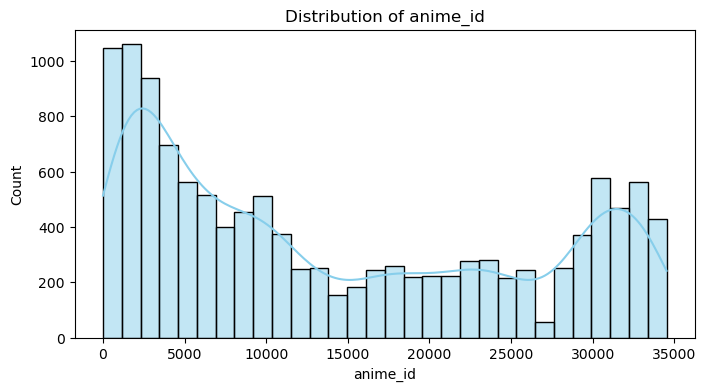

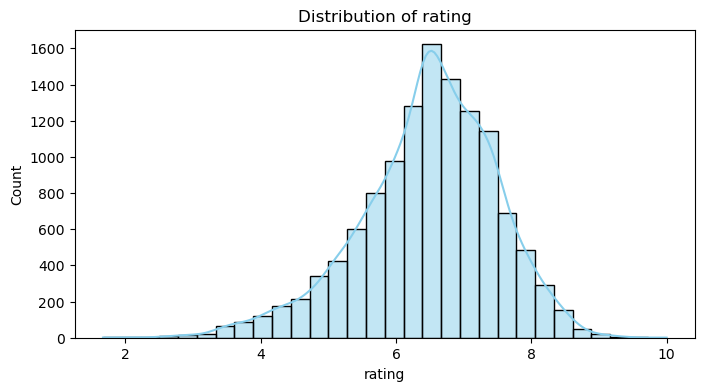

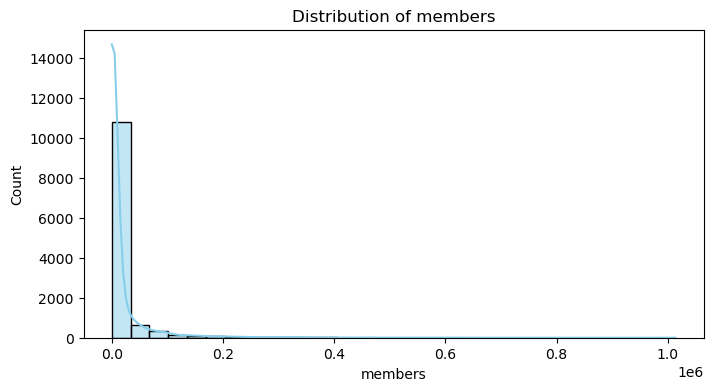

In [6]:
# Histogram for numeric column to see the distributions

for column in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column].dropna(), kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

In [7]:
# Converting categorical to numerical :
from scipy.sparse import hstack, csr_matrix

#1. Genres are multi-label (e.g., "Action, Comedy"), so we will use multi-hot encoding with CountVectorizer.
# Convert genre strings into a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern='[^, ]+') # We separate by comma and space, so set analyzer='word' and token_pattern accordingly
genre_matrix = vectorizer.fit_transform(df['genre'])

# 2. Type (One-hot Encoding)
type_dummies = pd.get_dummies(df['type'], prefix='type')
type_sparse = csr_matrix(type_dummies.values)  # Convert to sparse for concatenation

# 3. Episodes 
df.drop(columns='episodes', inplace=True)

# 4. Rating - btw 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_features = df[['rating']]
numsc = scaler.fit_transform(num_features)
num_sparse = csr_matrix(numsc) # Convert to sparse for concatenation

# 4. Combine all feature matrices horizontally
feature_matrix = hstack([genre_matrix, type_sparse, num_sparse])

#### Recommendation System:
Design a function to recommend anime based on cosine similarity.
<br>Given a target anime, recommend a list of similar anime based on cosine similarity scores.
<br>Experiment with different threshold values for similarity scores to adjust the recommendation list size.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_anime(anime_title, df, feature_matrix, top_n=10, min_similarity=0.3):
    """
    Recommends similar anime based on cosine similarity.
    
    Parameters:
    - anime_title: str, the name of the anime to find recommendations for
    - df: pandas DataFrame, the original dataset
    - feature_matrix: scipy sparse matrix, extracted features
    - top_n: int, number of recommendations to return
    - min_similarity: float, minimum similarity score to consider
    
    Returns:
    - List of recommended anime titles with their similarity scores
    """
    
    # Get index of the input anime
    if anime_title not in df['name'].values:
        return f"Anime titled '{anime_title}' not found in dataset."

    idx = df[df['name'] == anime_title].index[0] #Finds the row index in the DataFrame where the anime name matches anime_title

    # Compute cosine similarity between this anime and all others
    target_vector = feature_matrix[idx]
    similarities = cosine_similarity(target_vector, feature_matrix)[0]

    # Get indices of similar animes (excluding itself)
    similar_indices = similarities.argsort()[::-1][1:]  # [1:]skip index 0 (same anime)

    # Filter by similarity threshold and get top N
    recommendations = []
    for i in similar_indices:
        if similarities[i] >= min_similarity:
            recommendations.append((df.iloc[i]['name'], round(similarities[i], 3)))
        if len(recommendations) >= top_n:
            break

    return recommendations


#### Evaluation:
Split the dataset into training and testing sets.
<br>Evaluate the recommendation system using appropriate metrics such as precision, recall, and F1-score.
<br>Analyze the performance of the recommendation system and identify areas of improvement.

In [16]:
from sklearn.model_selection import train_test_split

# Split anime dataset by index
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# Train features
train_features = feature_matrix[train_idx]
train_df = df.loc[train_idx].reset_index(drop=True)

# Test set anime names and genres
test_df = df.loc[test_idx].reset_index(drop=True)

def genre_set(genre_str):
    return set(g.strip() for g in genre_str.split(','))

def evaluate_recommendations(top_n=5, min_similarity=0.3):
    precisions = []
    recalls = []
    
    for _, row in test_df.iterrows():
        anime_name = row['name']
        true_genres = genre_set(row['genre'])
        
        # Skip if no genre info
        if 'Unknown' in true_genres:
            continue
        
        # Recommend from train set using cosine similarity with train features
        # Find anime index in train_df by name or closest in train_df (approximate)
        # For simplicity, get similarities against train_features
        if anime_name not in df['name'].values:
            continue
        
        # Vector of the test anime (we have features for all)
        idx = df[df['name'] == anime_name].index[0]
        test_vector = feature_matrix[idx]
        
        sims = cosine_similarity(test_vector, train_features)[0]
        top_indices = sims.argsort()[::-1][:top_n]
        
        recommended_genres = []
        for i in top_indices:
            if sims[i] >= min_similarity:
                recommended_genres.append(genre_set(train_df.loc[i, 'genre']))
        
        # Flatten recommended genres
        rec_genres_flat = set().union(*recommended_genres) if recommended_genres else set()
        
        # Calculate precision and recall based on genre overlap
        if len(rec_genres_flat) == 0 or len(true_genres) == 0:
            continue
        
        precision = len(true_genres.intersection(rec_genres_flat)) / len(rec_genres_flat)
        recall = len(true_genres.intersection(rec_genres_flat)) / len(true_genres)
        
        precisions.append(precision)
        recalls.append(recall)
    
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall + 1e-8)
    
    return avg_precision, avg_recall, f1_score

# Run evaluation
precision, recall, f1 = evaluate_recommendations()
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")


Precision: 0.823, Recall: 0.985, F1-score: 0.897


In [19]:
# Areas of Improvement:
# 1. use user rating or watch history 
# 2. improve handling of multi-label genres

#### Interview Questions:
1. Can you explain the difference between user-based and item-based collaborative filtering?
<br>Collaborative Filtering is about recommending items based on the preferences of similar users or items. The two main types are:
<br>User-Based Collaborative Filtering: Finds users who are similar to the target user (based on rating patterns) and recommends items that similar users liked.
<br>Example: "People like you also liked..."
<br>Item-Based Collaborative Filtering: Finds items similar to what the user has already liked and recommends items that are most similar to the ones the user rated highly.
<br>Example: "If you liked this anime, you may also like..."

2. What is collaborative filtering, and how does it work?
<br>It relies on user behavior rather than item attributes.
<br>How it works:
<br>Steps:
<br>1.Collect user behavior data.
<br>2.Preprocess data.
<br>3.Build a model.
<br>4.Train the model.
<br>5.Make predictions.
<br>6.Generate recommendations.